<a href="https://colab.research.google.com/github/nilesh07g/Data-Science-3/blob/main/Final_Task3_nexus_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install lime


Importing libraries

In [4]:
import nltk
from google.colab import drive
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Download necessary NLTK resources
nltk.download('stopwords')   # For stopwords
nltk.download('punkt')       # For tokenizing text
nltk.download('wordnet')     # For lemmatization

# Mount Google Drive
drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load and Prepare Data

In [5]:
# Define file paths
train_file_path = '/content/drive/My Drive/NEXUS_INFO_PHASE2_DATASET/combined_train.csv'
test_file_path = '/content/drive/My Drive/NEXUS_INFO_PHASE2_DATASET/testdata.manual.2009.06.14.csv'

# Load training data, skipping the first row which contains headings
train_df = pd.read_csv(train_file_path, encoding='latin-1', header=None, skiprows=1)
train_df = train_df[[0, 2]]  # Selecting polarity and text columns
train_df.columns = ['polarity', 'text']  # Renaming columns for clarity

# Load testing data
test_df = pd.read_csv(test_file_path, encoding='latin-1', header=None)
test_df = test_df[[0, 5]]  # Selecting polarity and text columns
test_df.columns = ['polarity', 'text']  # Renaming columns for clarity





<ipython-input-5-b00be0912426>:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_file_path, encoding='latin-1', header=None, skiprows=1)


 Data Exploration

In [6]:
# Check the loaded data
train_df.head()

,polarity,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [7]:
test_df.head()

,polarity,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


Data prepossing

In [8]:
# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Handle non-string entries
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])  # Tokenize and lemmatize
    return text

# Apply preprocessing to 'text' columns
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)



In [9]:
# Check values again
train_df.head()



,polarity,text
0,0,upset update facebook texting might cry result...
1,0,kenichan dived many time ball managed save 50 ...
2,0,whole body feel itchy like fire
3,0,nationwideclass behaving mad see
4,0,kwesidei whole crew


In [10]:
test_df.head()

,polarity,text
0,4,stellargirl loooooooovvvvvveee kindle2 dx cool...
1,4,reading kindle2 love lee child good read
2,4,ok first assesment kindle2 fucking rock
3,4,kenburbary love kindle2 mine month never looke...
4,4,mikefish fair enough kindle2 think perfect


 Text Vectorization

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer with a limit on the number of features
vectorizer = TfidfVectorizer(max_features=2000)

# Fit and transform the training data to create a sparse matrix
X_train_sparse = vectorizer.fit_transform(train_df['text'])

# Transform the test data using the same vectorizer
X_test_sparse = vectorizer.transform(test_df['text'])

# Extract the target variables
y_train = train_df['polarity']
y_test = test_df['polarity']

# Check the shape of the resulting matrices
print("X_train_sparse shape:", X_train_sparse.shape)
print("X_test_sparse shape:", X_test_sparse.shape)


X_train_sparse shape: (1076053, 2000)
X_test_sparse shape: (516, 2000)


Handle Class Imbalance with Random Over-sampling

In [12]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_sparse, y_train)

# Check the shape of the resampled data
print("Resampled X_train shape:", X_train_resampled.shape)
print("Resampled y_train shape:", y_train_resampled.shape)


Resampled X_train shape: (2423331, 2000)
Resampled y_train shape: (2423331,)


 Model Selection

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model = MultinomialNB()
model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred = model.predict(X_test_sparse)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6453488372093024
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       178
           2       0.56      0.63      0.59       140
           4       0.67      0.65      0.66       198

    accuracy                           0.65       516
   macro avg       0.64      0.64      0.64       516
weighted avg       0.65      0.65      0.65       516



Hyperparameter Tuning

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for alpha
param_grid = {'alpha': [0.1, 0.5, 1.0]}

# Initialize the GridSearchCV object with the Naive Bayes model and the parameter grid
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)

# Fit the model on the resampled data
grid_search.fit(X_train_resampled, y_train_resampled)

# Output the best parameters
print("Best Parameters:", grid_search.best_params_)

# Update the model with the best parameters
model = grid_search.best_estimator_


Best Parameters: {'alpha': 1.0}


Cross-Validation

In [15]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the resampled data
scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)

# Output the mean cross-validation score
print("Mean Cross-Validation Score:", scores.mean())


Mean Cross-Validation Score: 0.5699143061122195


Model Interpretability

In [16]:
from lime.lime_text import LimeTextExplainer

# Initialize the LIME text explainer with the class names
explainer = LimeTextExplainer(class_names=['negative', 'neutral', 'positive'])

# Define a function to use the vectorizer and model
def predict_proba(texts):
    X_text = vectorizer.transform(texts)
    return model.predict_proba(X_text)

# Select an example from the test data
sample_text = test_df['text'].iloc[0]  # Raw text from the test data

# Explain the instance using the wrapper function
exp = explainer.explain_instance(sample_text, predict_proba, num_features=6)

# Display the explanation in a notebook
exp.show_in_notebook()


 Evaluation Metrics

Classes in model: [0 2 4]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


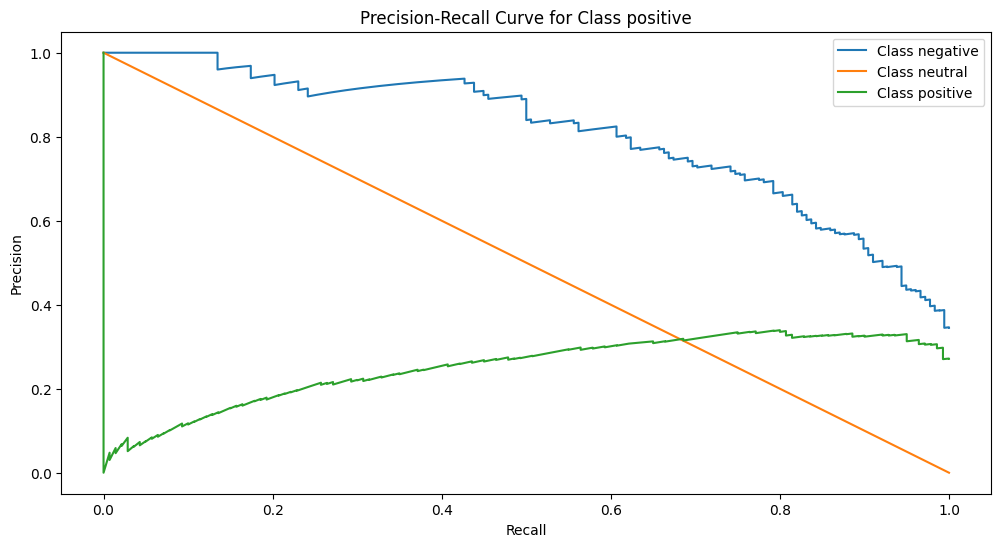

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


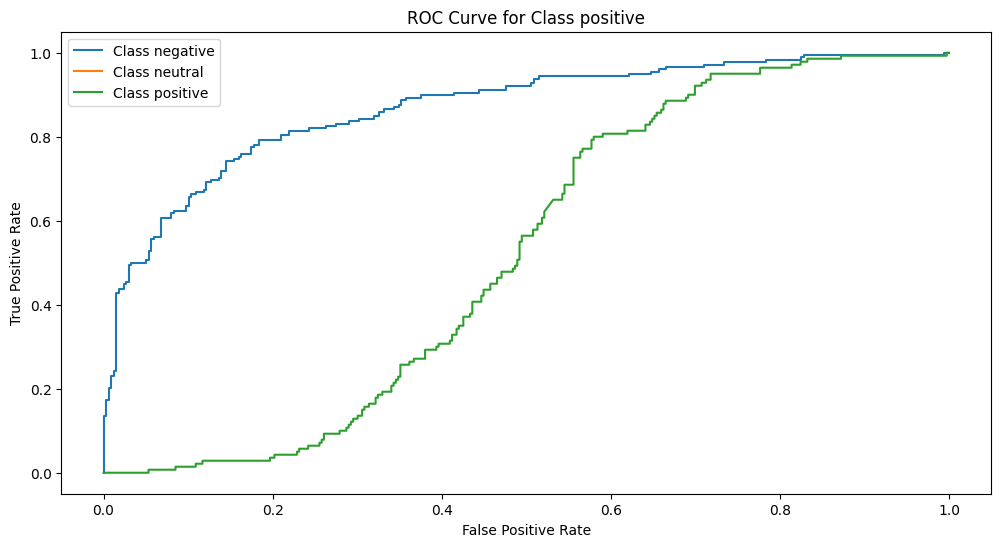

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check the number of classes predicted by the model
print("Classes in model:", model.classes_)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test_sparse)

# Determine the number of classes in the model
num_classes = y_pred_proba.shape[1]

# Define plotting functions
def plot_precision_recall_curve(y_true, y_scores, class_index, class_label):
    if num_classes <= class_index:
        print(f"Skipping Precision-Recall curve for {class_label} (class index out of bounds)")
        return
    precision, recall, _ = precision_recall_curve(y_true == class_index, y_scores[:, class_index])
    plt.plot(recall, precision, label=f'Class {class_label}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Class {class_label}')
    plt.legend()

def plot_roc_curve(y_true, y_scores, class_index, class_label):
    if num_classes <= class_index:
        print(f"Skipping ROC curve for {class_label} (class index out of bounds)")
        return
    fpr, tpr, _ = roc_curve(y_true == class_index, y_scores[:, class_index])
    plt.plot(fpr, tpr, label=f'Class {class_label}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {class_label}')
    plt.legend()

# Plot Precision-Recall curves for each class
plt.figure(figsize=(12, 6))
for i, label in enumerate(['negative', 'neutral', 'positive']):
    plot_precision_recall_curve(y_test, y_pred_proba, i, label)
plt.show()

# Plot ROC curves for each class
plt.figure(figsize=(12, 6))
for i, label in enumerate(['negative', 'neutral', 'positive']):
    plot_roc_curve(y_test, y_pred_proba, i, label)
plt.show()




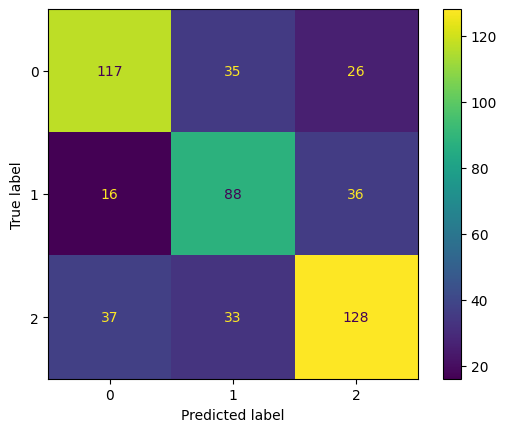

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, model.predict(X_test_sparse))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()